# Inteligencia Artificial
# Clase 19 - API Funcional de Keras

## Prediciendo precios de vinos con un modelo *multi-input*

En esta notebook vamos a presentar la API funcional de Keras. Trabajaremos con un [dataset de *reviews* de vinos](https://www.kaggle.com/zynicide/wine-reviews) para desarrollar un modelo que pueda predecir el precio a partir del texto de la reseña y otros atributos del vino, tales como su país de origen, el puntaje asignado y la variedad, entre otros. Vamos a introducir la clase `Model`, una alternativa a la clase `Sequential` que venimos utilizando hasta el momento para construir nuestras redes neuronales. Comenzaremos presentando la sintaxis de la API funcional con un modelo *fully-connected* y otro recurrente, para luego desarrollar un modelo *multi-input* que conjugue datos estructurados (matriz de *features*) y datos no estrucurados (secuencias de texto) en una única arquitectura de red neuronal.

Este ejercicio y parte del código de esta notebook están inspirados en un [artículo del blog oficial de TensorFlow](https://medium.com/tensorflow/predicting-the-price-of-wine-with-the-keras-functional-api-and-tensorflow-a95d1c2c1b03).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

El dataset con el que vamos a trabajar está colgado en Kaggle y se construyó a partir de *scraping* del sitio [WineEnthusiast](http://www.winemag.com/?s=&drink_type=wine). Usamos la API de Kaggle para descargar el dataset:

In [0]:
# Ubicamos las credenciales de Kaggle en el directorio indicado por la API
%%bash
mkdir -p ~/.kaggle
mv kaggle.json ~/.kaggle/
chmod 600 ~/.kaggle/kaggle.json
cat ~/.kaggle/kaggle.json

In [0]:
# Descargamos los datos
# https://www.kaggle.com/zynicide/wine-reviews/data
%%bash
kaggle datasets download -d zynicide/wine-reviews -f winemag-data_first150k.csv
unzip winemag-data_first150k.csv.zip
rm winemag-data_first150k.csv.zip

In [0]:
# Leemos el .csv con Pandas
data = pd.read_csv('winemag-data_first150k.csv', index_col='Unnamed: 0')
data.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [0]:
# Inspeccionamos la información de la tabla
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150930 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      150925 non-null  object 
 1   description  150930 non-null  object 
 2   designation  105195 non-null  object 
 3   points       150930 non-null  int64  
 4   price        137235 non-null  float64
 5   province     150925 non-null  object 
 6   region_1     125870 non-null  object 
 7   region_2     60953 non-null   object 
 8   variety      150930 non-null  object 
 9   winery       150930 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 12.7+ MB


Tenemos más de 150 mil reseñas de vinos en nuestro dataset. Además del texto de la *review*, contamos con ciertos metadatos del vino: país de origen, provincia y región, vinería, designación, variedad, puntaje y precio. El objetivo será entrenar un modelo de regresión que prediga los precios de los distintos vinos en particular a partir de esta informacion.

Comenzamos filtrando los registros en que falta el dato de país y precio:

In [0]:
# Conservamos vinos con país y precio no nulos
data = data[pd.notnull(data['country'])]
data = data[pd.notnull(data['price'])]
print('Luego de esta limpieza, quedan {} registros.'.format(len(data)))

Luego de esta limpieza, quedan 137230 registros.


Exploramos los países productores de vinos más representados en el dataset:

In [0]:
data['country'].value_counts().round(2).head(10)

US             62139
Italy          18784
France         14785
Spain           8160
Chile           5766
Argentina       5587
Australia       4894
Portugal        4176
New Zealand     3070
Austria         2483
Name: country, dtype: int64

Analizamos la distribución de variedades:

In [0]:
data['variety'].value_counts()

Chardonnay            13775
Pinot Noir            13625
Cabernet Sauvignon    12671
Red Blend              9377
Sauvignon Blanc        6054
                      ...  
Moscato di Noto           1
Premsal                   1
Garnacha Tintorera        1
Früburgunder              1
Vitovska                  1
Name: variety, Length: 619, dtype: int64

In [0]:
data['variety'].value_counts().describe(percentiles=[.05, .25, .5, .75, .9, .95])

count      619.000000
mean       221.696284
std       1152.687086
min          1.000000
5%           1.000000
25%          2.000000
50%          7.000000
75%         34.000000
90%        195.800000
95%        796.100000
max      13775.000000
Name: variety, dtype: float64

In [0]:
# Limitamos la cantidad de variedades de vinos en el dataset
# Cualquier variedad con menos de 500 ocurrencias será descartada
variety_threshold = 500
value_counts = data['variety'].value_counts()
to_remove = value_counts[value_counts <= variety_threshold].index
data = data.loc[~data['variety'].isin(to_remove)]
print('Luego de esta limpieza, quedan {} registros.'.format(len(data)))

Luego de esta limpieza, quedan 119559 registros.


Analizamos la distribución de precios:

In [0]:
data['price'].describe()

count    119559.000000
mean         34.194473
std          37.526179
min           4.000000
25%          16.000000
50%          25.000000
75%          40.000000
max        2300.000000
Name: price, dtype: float64

Visualizamos la relación entre puntaje y precio:

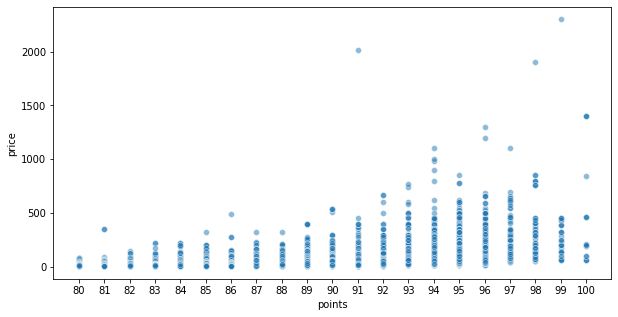

In [0]:
plt.figure(figsize=(10,5))
sns.scatterplot(data=data, x='points', y='price', alpha=.5)
plt.xticks(ticks=range(80, 100+1));

Exploramos los países, variedades, vinerías y designaciones con mayores precios medios:

In [0]:
# Países
print('Hay {} países distintos.'.format(len(data['country'].unique())), '\n')
data.groupby('country')['price'].aggregate([np.mean, np.std]).sort_values(by='mean', ascending=False).round(2).head(10)

Hay 41 países distintos. 



,mean,std
country,,
US-France,50.00,NaN
France,47.98,72.68
England,47.50,11.96
Italy,42.44,41.27
Luxembourg,40.67,7.00
Germany,38.99,58.19
US,33.89,24.95
Serbia,32.80,10.83
Turkey,32.77,26.13


In [0]:
# Variedades
print('Hay {} variedades distintas.'.format(len(data['variety'].unique())), '\n')
data.groupby('variety')['price'].aggregate([np.mean, np.std]).sort_values(by='mean', ascending=False).round(2).head(10)

Hay 40 variedades distintas. 



,mean,std
variety,,
Champagne Blend,78.63,74.92
Nebbiolo,66.41,45.78
Sangiovese Grosso,60.61,41.53
Port,51.80,64.83
Bordeaux-style Red Blend,49.16,72.68
"Corvina, Rondinella, Molinara",46.46,42.42
Pinot Noir,44.09,33.39
Cabernet Sauvignon,42.15,35.25
Bordeaux-style White Blend,36.72,91.34


In [0]:
# Vinerías y designaciones
print('Hay {} vinerías distintas y {} designaciones distintas.'.format(len(data['winery'].unique()), len(data['designation'].unique())), '\n')
display(data.groupby('winery')['price'].aggregate([np.mean, np.std]).sort_values(by='mean', ascending=False).round(2).head(10))
display(data.groupby('designation')['price'].aggregate([np.mean, np.std]).sort_values(by='mean', ascending=False).round(2).head(10))

Hay 12677 vinerías distintas y 24386 designaciones distintas. 



,mean,std
winery,,
Blair,1029.00,1391.59
Château Latour,794.40,866.02
Masseto,587.50,53.03
Château Haut-Brion,569.09,348.60
Château La Mission Haut-Brion,568.17,432.00
Krug,513.25,447.73
Château Ausone,495.00,502.05
Domaine Perrot-Minot,421.25,94.99
Château Lafite Rothschild,406.00,180.36


,mean,std
designation,,
Clos du Mesnil,1400.0,0.00
Roger Rose Vineyard,1021.5,1402.19
Colheita White,980.0,NaN
Les Quatre Journaux,740.0,NaN
Kiedrich Gräfenberg Trockenbeerenauslese,700.4,72.10
Hill of Grace,625.0,NaN
Figuero Tinus,599.0,NaN
La Cabotte,596.0,87.64
Very Old Single Harvest,588.0,NaN


Para mantener acotada la dimensionalidad del problema, nos focalizaremos en las siguientes variables:

- Descripción
- Puntaje
- País de origen
- Provincia de origen
- Variedad

Para construir el regresor, tendremos dos aproximaciones distintas:

1. Por un lado, entrenaremos una red densamente conectada que prediga el precio a partir del puntaje, país y provincia de origen y variedad. Por otro lado, entrenaremos una red recurrente que prediga el precio a partir del texto de la descripción del vino. Con ambos modelos construiremos un ensamble en donde la predicción será el resultado de promediar las estimaciones de cada una de las partes. 
2. Por otro lado, entrenaremos un único modelo *multi-input* que constará de una rama *fully-connected* y de otra rama recurrente, cuyos *outputs* tendremos que concatenar en un única capa de salida antes de generar la predicción final.

En todos los casos, usaremos la API funcional para ir ganando familiaridad con su sintaxis.

Separamos los datos en train y test:

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(['designation', 'region_1', 'region_2', 'winery', 'price'], axis=1),
                                                    data['price'],
                                                    test_size=.10, random_state=42)

In [0]:
print('Cantidad de registros en train:', len(X_train))
print('Cantidad de registros en test:', len(X_test))

Cantidad de registros en train: 107603
Cantidad de registros en test: 11956


In [0]:
X_train.head()

,country,description,points,province,variety
97670,Chile,Cuvée Alexandre is one of Chile's best Merlots...,90,Colchagua Valley,Merlot
9724,Spain,"Aromas of wet rock, chewing gum and mild citru...",85,Northern Spain,Rosé
127845,US,"Soft and semisweet, with the honeyed, lemon-an...",83,California,Sauvignon Blanc
144977,US,"Dry and tannic, a real mountain wine that's ti...",90,California,Cabernet Sauvignon
10783,France,"Cantenac Brown is on a roll now, and even in l...",94,Bordeaux,Bordeaux-style Red Blend


Generamos las *dummies* de las variables categóricas:

In [0]:
categoricals = ['country', 'province', 'variety']
dummy_train = pd.get_dummies(X_train[categoricals], drop_first=True)
dummy_train.shape

(107603, 469)

Estandarizamos la variable de puntaje:

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[['points']])
points = scaler.transform(X_train[['points']])

Definimos la matriz de *features* de entrenamiento:

In [0]:
input_train = dummy_train.join(pd.Series(points.ravel(), index=X_train.index, name='points'))
input_train.head()

,country_Australia,country_Austria,country_Brazil,country_Bulgaria,country_Canada,country_Chile,country_China,country_Croatia,country_Cyprus,country_Czech Republic,...,variety_Sauvignon Blanc,variety_Shiraz,variety_Sparkling Blend,variety_Syrah,variety_Tempranillo,variety_Tempranillo Blend,variety_Viognier,variety_White Blend,variety_Zinfandel,points
97670,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.656412
9724,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.875700
127845,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-1.488545
144977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.656412
10783,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.882102


## Ensamble de modelos

Como primer modelo del ensamble, proponemos una arquitectura que consta de dos capas densas de 256 y 128 neuronas, respectivamente, y una capa de salida lineal con un solo nodo. Usaremos *dropout* para regularizar.
Sabemos que con la clase `Sequential`, la construcción de esta arquitectura es así:

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, input_dim=input_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               120576    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 153,601
Trainable params: 153,601
Non-trainable params: 0
_________________________________________________________________


Ahora, veamos cómo definir la misma red con la clase `Model` y la sintaxis de la API funcional:

In [0]:
# Importamos las clases Model e Input del módulo de modelos y capas, respectivamente
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Definimos una variable que será una instancia de la clase Input
# donde especificamos las dimensiones de los datos de entrada
input_layer = Input(shape=(input_train.shape[1],))

# Definimos una variable distinta para cada capa del modelo
dense_layer_1 = Dense(256, activation='relu')(input_layer)

# Cada capa es una función que mapea datos de entrada hacia una salida
# Y cada salida se convienrte en la entrada (argumento) de la siguiente función
dropout_layer_1 = Dropout(0.2)(dense_layer_1)

# Es importante encadenar correctamente las entradas y salidas de cada capa 
dense_layer_2 = Dense(128, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.2)(dense_layer_2)
output_layer = Dense(1)(dropout_layer_2)

# Generamos una instancia del modelo con la clase Model
model = Model(input_layer, output_layer) # Debemos aclarar las variables de input y output

In [0]:
# Vemos que el summary del modelo es exactamente el mismo
# salvo que ahora se especifica la InputLayer, antes omitida
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 470)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               120576    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 153,601
Trainable params: 153,601
Non-trainable params: 0
_______________________________________________________

Dado que se trata de un problema de regresión, nos interesará evaluar como métrica de *performance* el $R^2$ del modelo. Como Keras no ofrece esta métrica de evaluación directamente, definimos nuestra propia función de evaluación utilizando el backend de Keras:

In [0]:
# Definimos una función que computa el R2 score
from tensorflow.keras import backend as K

def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [0]:
# Compilamos el modelo
model.compile(optimizer='adam',
              loss='mse',
              metrics=[r2_score, 'mae'])

In [0]:
# Definimos un criterio de Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

In [0]:
# Entrenamos el modelo
model.fit(input_train, y_train, batch_size=32,
          epochs=30, validation_split=0.1, callbacks=[es])

Train on 96842 samples, validate on 10761 samples
Epoch 1/30
96842/96842 [==============================] - 11s 113us/sample - loss: 808.1671 - r2_score: 0.3409 - mae: 13.2981 - val_loss: 771.8297 - val_r2_score: 0.4549 - val_mae: 12.3846
Epoch 2/30
96842/96842 [==============================] - 10s 108us/sample - loss: 723.0637 - r2_score: 0.3957 - mae: 12.4352 - val_loss: 736.8914 - val_r2_score: 0.3946 - val_mae: 12.8660
Epoch 3/30
96842/96842 [==============================] - 10s 106us/sample - loss: 705.7455 - r2_score: 0.4048 - mae: 12.2904 - val_loss: 722.0115 - val_r2_score: 0.3617 - val_mae: 12.5466
Epoch 4/30
96842/96842 [==============================] - 10s 102us/sample - loss: 691.4889 - r2_score: 0.4046 - mae: 12.2025 - val_loss: 718.5050 - val_r2_score: 0.4265 - val_mae: 12.2335
Epoch 5/30
96842/96842 [==============================] - 10s 102us/sample - loss: 681.9472 - r2_score: 0.4176 - mae: 12.1379 - val_loss: 723.6847 - val_r2_score: 0.3309 - val_mae: 12.9716
Epoch

Evaluamos el modelo sobre test, habiendo hecho previamente el preprocesamiento de los datos necesario:

In [0]:
# Generamos las dummies de las variables categóricas
dummy_test = pd.get_dummies(X_test[categoricals], drop_first=True)
dummy_test.shape

(11956, 321)

Dado el azar del *split* entre train y test, vemos que en el conjunto de testeo tenemos menos variables *dummies* que en el conjunto de entrenamiento, por lo que debemos generar vectores nulos para las categorías faltantes:

In [0]:
# Hacemos coincidir las dummies de ambos set imputando con 0 todas las categorías ausentes
dummy_test = dummy_test.reindex(columns = dummy_train.columns, fill_value=0)
dummy_test.shape

(11956, 469)

In [0]:
# Estandarizamos la variable de puntaje con los parámetros aprendidos en train
test_points = scaler.transform(X_test[['points']])

In [0]:
# Set de test
input_test = dummy_test.join(pd.Series(test_points.ravel(), index=X_test.index, name='points'))
input_test.head()

,country_Australia,country_Austria,country_Brazil,country_Bulgaria,country_Canada,country_Chile,country_China,country_Croatia,country_Cyprus,country_Czech Republic,...,variety_Sauvignon Blanc,variety_Shiraz,variety_Sparkling Blend,variety_Syrah,variety_Tempranillo,variety_Tempranillo Blend,variety_Viognier,variety_White Blend,variety_Zinfandel,points
103972,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.569278
107654,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.875700
37339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.794968
101107,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,-0.262855
39061,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.656412


In [0]:
# Evaluamos el modelo
model.evaluate(input_test, y_test)

11956/11956 [==============================] - 1s 44us/sample - loss: 997.7816 - r2_score: 0.4204 - mae: 12.2220


[997.7815583663945, 0.42044696, 12.221953]

Nuestro modelo densamente conectado alcanza un $R^2$ del orden del 0.4 y tiene un error absoluto medio de unos 12 dólares.

Ahora, desarrollaremos un modelo recurrente que aprende a predecir el precio de un vino a partir del texto de la *review*. Éste será el segundo componente de nuestro ensamble. Trabajaremos con una GRU que procesará las secuencias de texto, donde cada palabra será representada por un `Embedding` de 100 dimensiones.

Empezamos convirtiendo cada descripción en una secuencia utilizando el método `texts_to_sequences()` de la clase `Tokenizer`. Este método devuelve una lista de enteros por cada texto, donde cada entero representa una palabra distinta.

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Creamos una instancia de Tokenizer, limitando el número de palabras a las 10000 más frecuentes
tokenizer = Tokenizer(num_words=10000)

# Lo ajustamos a nuestro corpus de texto
tokenizer.fit_on_texts(X_train['description'])
print('Hay {} palabras en el vocabulario del corpus de entrenamiento, pero el tokenizador sólo conserva {}.'.format(len(tokenizer.word_index), tokenizer.num_words))

Hay 31892 palabras en el vocabulario del corpus de entrenamiento, pero el tokenizador sólo conserva 10000.


In [0]:
# Generamos las secuencias de palabras con texts_to_sequences()
train_sequences = tokenizer.texts_to_sequences(X_train['description'])
print(train_sequences[0])

[1448, 8838, 7, 100, 4, 3172, 143, 2221, 1, 1655, 7, 39, 1444, 4620, 1079, 281, 12, 46, 95, 471, 208, 1, 228, 189, 11, 3003, 1591, 10, 885, 2, 9, 83, 805, 35, 1, 50, 20, 455, 31, 233, 27, 128, 50, 1, 292, 63, 8, 3, 3022, 9, 5, 3, 98, 4, 577, 1, 52, 15, 2, 18, 32, 38, 80, 612]


Analizamos la distribución de longitud de las reseñas:

In [0]:
pd.Series([len(sequence) for sequence in train_sequences]).describe(percentiles=[.5,.75,.9,.95, .99])

count    107603.000000
mean         40.763826
std          11.823570
min           0.000000
50%          40.000000
75%          48.000000
90%          56.000000
95%          61.000000
99%          73.000000
max         134.000000
dtype: float64

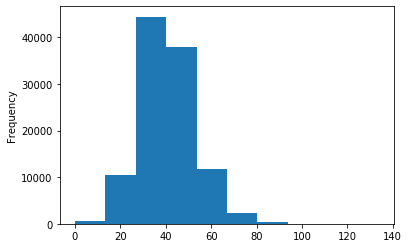

In [0]:
pd.Series([len(sequence) for sequence in train_sequences]).plot(kind='hist');

Vamos a homogenizar el largo de las secuencias definiendo un largo máximo de 70 palabras, con el cual sabemos estaremos recortando apenas menos del 1% de los documentos del *corpus*. Para esto, usaremos la función `pad_sequences()`, disponible en el módulo de preprocesamiento de secuencias. Esta función se encarga de hacer un *zero padding* de secuencias de largo inferior al argumento `maxlen` y de recortar las secuencias de largo mayor.

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 70
print('Longitud de la primera secuencia antes del pad:', len(train_sequences[0]))
train_sequences = pad_sequences(train_sequences, maxlen=maxlen)
print('Longitud de la primera secuencia después del pad:', len(train_sequences[0]))

Longitud de la primera secuencia antes del pad: 64
Longitud de la primera secuencia después del pad: 70


In [0]:
# Vemos que se rellenó con 0 los timesteps faltantes hasta alcanzar los 70 de maxlen
train_sequences[0]

array([   0,    0,    0,    0,    0,    0, 1448, 8838,    7,  100,    4,
       3172,  143, 2221,    1, 1655,    7,   39, 1444, 4620, 1079,  281,
         12,   46,   95,  471,  208,    1,  228,  189,   11, 3003, 1591,
         10,  885,    2,    9,   83,  805,   35,    1,   50,   20,  455,
         31,  233,   27,  128,   50,    1,  292,   63,    8,    3, 3022,
          9,    5,    3,   98,    4,  577,    1,   52,   15,    2,   18,
         32,   38,   80,  612], dtype=int32)

Recordamos cómo definir nuestro modelo recurrente con la clase `Sequential`:

In [0]:
from tensorflow.keras.layers import Embedding, GRU

gru_model = Sequential()
# La capa de embedding aprende una representación densa de las palabras
# Recibe como input_dim  el tamaño del vocabulario
gru_model.add(Embedding(input_dim=tokenizer.num_words, output_dim=100))
# Genera una representación de 100 dimensiones para cada palabra como salida
# El tensor de embeddings es de dimensiones (batch_size, input_length, output_dim)
# por lo que puede ser usado como entrada de una capa recurrente
gru_model.add(GRU(32, dropout=0.2, recurrent_dropout=0.2)) # Incorporamos dropout recurrente
gru_model.add(Dense(1))

gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
gru (GRU)                    (None, 32)                12864     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,012,897
Trainable params: 1,012,897
Non-trainable params: 0
_________________________________________________________________


Ahora, veamos cómo reproducir este mismo modelo con la API funcional:

In [0]:
input_sequence = Input(shape=(train_sequences.shape[1],))
embedding_layer = Embedding(tokenizer.num_words, 100)(input_sequence)
gru_layer = GRU(32, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
gru_output_layer = Dense(1)(gru_layer)

gru_model = Model(input_sequence, gru_output_layer)
gru_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 70, 100)           1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12864     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,012,897
Trainable params: 1,012,897
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compilamos el modelo
gru_model.compile(optimizer='adam', loss='mse', metrics=[r2_score, 'mae'])

# Entrenamos
gru_model.fit(train_sequences, y_train,
              batch_size=32, epochs=30,
              validation_split=0.1, callbacks=[es])

Train on 96842 samples, validate on 10761 samples
Epoch 1/30
96842/96842 [==============================] - 138s 1ms/sample - loss: 1360.3217 - r2_score: -0.0661 - mae: 18.0639 - val_loss: 1241.8444 - val_r2_score: 0.2449 - val_mae: 15.3249
Epoch 2/30
96842/96842 [==============================] - 144s 1ms/sample - loss: 1052.3797 - r2_score: 0.2955 - mae: 14.3336 - val_loss: 1082.6035 - val_r2_score: 0.3495 - val_mae: 14.1182
Epoch 3/30
96842/96842 [==============================] - 127s 1ms/sample - loss: 939.1209 - r2_score: 0.3814 - mae: 13.2959 - val_loss: 1017.7767 - val_r2_score: 0.3810 - val_mae: 13.5440
Epoch 4/30
96842/96842 [==============================] - 137s 1ms/sample - loss: 868.9448 - r2_score: 0.4187 - mae: 12.7087 - val_loss: 979.8745 - val_r2_score: 0.3489 - val_mae: 13.6961
Epoch 5/30
96842/96842 [==============================] - 144s 1ms/sample - loss: 811.5434 - r2_score: 0.4562 - mae: 12.2934 - val_loss: 939.5529 - val_r2_score: 0.3926 - val_mae: 13.1491
Epoc

Evaluamos la *performance* de este modelo recurrente en test:

In [0]:
# Obtenemos las secuencias y hacemos el padding
test_sequences = tokenizer.texts_to_sequences(X_test['description'])
test_sequences = pad_sequences(test_sequences, maxlen=maxlen)

In [0]:
gru_model.evaluate(test_sequences, y_test)

11956/11956 [==============================] - 3s 273us/sample - loss: 1201.4487 - r2_score: 0.3440 - mae: 12.3275


[1201.4486501750519, 0.34399688, 12.327508]

El modelo recurrente alcanza métricas de evaluación similares a las del modelo densamente conectado, pero es considerablemente más costoso.

Notemos que del total de paráemtros entrenables, el grueso (1 millón) corresponden a la capa de embeddings. Como alternativa, veamos ahora qué ocurre si en lugar de entrenar desde cero nuestra capa de embeddings, hacemos *transfer learning* y aprovechamos los embeddings pre-entrenados de [GloVe](https://nlp.stanford.edu/projects/glove/). Necesitaremos descargar el archivo [glove.6B.zip](http://nlp.stanford.edu/data/glove.6B.zip) y extraer los archivos de texto que contienen los vectores que representan a las palabras del *corpus* de entrenamiento. En el zip hay embeddings de distintas dimensiones, nosotros utilizaremos el de 100 para poder comparar con la red anterior.

In [0]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

In [0]:
# Leemos el archivo y construimos un diccionario de pares (palabra, embedding)
import os
glove_dir = '/content/'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Hay {} embedding de palabras.'.format(len(embeddings_index))) 

Hay 400000 embedding de palabras.


In [0]:
# Construimos la matriz de embeddings
max_words = tokenizer.num_words
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
word_index = tokenizer.word_index

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Para ilustrar algunas de las virtudes de los embeddings, vamos a ver que los vectores de palabras con similitudes semánticas se encuentran cercanas entre sí. Para medir esta similitud, tomamos la métrica de la similitud coseno, que se define como:

$$\text{similitud_coseno(u, v)} = \frac {u . v} {||u||_2 ||v||_2} = cos(\theta) \tag{1}$$

donde $u.v$ es el producto escalar de los vectores, $||u||_2$ es la norma 2 del vector $u$, $||v||_2$ es la norma 2 del vector $v$ y $\theta$ es el ángulo entre $u$ y $v$. Por lo tanto, esta similitud depende del ángulo entre $u$ y $v$. Si $u$ y $v$ son muy parecidos, su similitud coseno estará cerca de 1; si son muy distintos, su similitud coseno tomará un valor menor.

<img src="http://blog.christianperone.com/wp-content/uploads/2013/09/cosinesimilarityfq1.png">

<center>El coseno de un ángulo entre dos vectores mide cuán parecidos son.<center>

In [0]:
def cosine_similarity(u, v):
    # Calculamos el producto escalar de u y v
    dot = np.dot(u,v)
    # Calculamos la norma L2 de u
    norm_u = np.sqrt(np.sum(np.power(u,2)))
    # Calculamos la norma L2 de v
    norm_v = np.sqrt(np.sum(np.power(v,2)))
    # Aplicamos la fórmula de la similitud coseno
    cosine_similarity = dot/(norm_u*norm_v)
    return cosine_similarity

In [0]:
# A continuación, utilizamos el diccionario de embeddings de GloVe para extraer los vectores correspondientes a algunas palabras
father = embeddings_index["father"]
mother = embeddings_index["mother"]
ball = embeddings_index["ball"]
crocodile = embeddings_index["crocodile"]

# Cada vector es unidimensional de tamaño 100
print(father.shape, mother.shape)

(100,) (100,)


A continuación, podemos calcular la similitud coseno para evaluar relaciones entre palabras:

In [0]:
# Esperamos que sea cercana a 1
print('cosine_similarity(father, mother) =', cosine_similarity(father, mother))

# Esperamos que sea cercana a 0
print('cosine_similarity(ball, crocodile) =',cosine_similarity(ball, crocodile))

cosine_similarity(father, mother) = 0.8656661
cosine_similarity(ball, crocodile) = 0.15206575


Para incorporar estos embeddings pre-entrenados a nuestro modelo, debemos asignarlos como pesos de la capa de `Embedding` y *freezarla* para no actualizarlos:

In [0]:
from tensorflow.keras import backend as K
K.clear_session()

# Redefinimos el modelo recurrente
input_sequence = Input(shape=(train_sequences.shape[1],))
embedding_layer = Embedding(tokenizer.num_words, 100)(input_sequence)
gru_layer = GRU(32, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
gru_output_layer = Dense(1)(gru_layer)
gru_model = Model(input_sequence, gru_output_layer)

# Seteamos los pesos de la capa de embedding de acuerdo a los vectores de GloVe
gru_model.layers[1].set_weights([embedding_matrix])
# Freezamos esta capa
gru_model.layers[1].trainable = False

gru_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 70, 100)           1000000   
_________________________________________________________________
gru (GRU)                    (None, 32)                12864     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,012,897
Trainable params: 12,897
Non-trainable params: 1,000,000
_________________________________________________________________


In [0]:
# Compilamos el modelo
gru_model.compile(optimizer='adam', loss='mse', metrics=[r2_score, 'mae'])

# Entrenamos
gru_model.fit(train_sequences, y_train,
              batch_size=32, epochs=30,
              validation_split=0.1, callbacks=[es])

Train on 96842 samples, validate on 10761 samples
Epoch 1/30
96842/96842 [==============================] - 118s 1ms/sample - loss: 1388.9832 - r2_score: -0.1036 - mae: 18.6008 - val_loss: 1308.6047 - val_r2_score: 0.1572 - val_mae: 16.7663
Epoch 2/30
96842/96842 [==============================] - 122s 1ms/sample - loss: 1155.0178 - r2_score: 0.1637 - mae: 16.2923 - val_loss: 1200.0017 - val_r2_score: 0.1945 - val_mae: 16.1704
Epoch 3/30
96842/96842 [==============================] - 122s 1ms/sample - loss: 1096.5554 - r2_score: 0.2056 - mae: 15.7945 - val_loss: 1155.9222 - val_r2_score: 0.1880 - val_mae: 16.2834
Epoch 4/30
96842/96842 [==============================] - 121s 1ms/sample - loss: 1065.0638 - r2_score: 0.2171 - mae: 15.4864 - val_loss: 1117.5183 - val_r2_score: 0.2194 - val_mae: 15.6859
Epoch 5/30
96842/96842 [==============================] - 116s 1ms/sample - loss: 1041.4382 - r2_score: 0.2304 - mae: 15.3188 - val_loss: 1092.8442 - val_r2_score: 0.2300 - val_mae: 15.4295

Esta nueva red con embeddings pre-entrenados es más barata de entrenar que la anterior, pero necesita más iteraciones hasta alcanzar el mismo o mejor *score* en el set de validación. Esto puede deberse al hecho de que en el primer caso, las dimensiones de los embeddings aprendidos son especificos para el problema en cuestión, mientras que en este otro caso, los embeddings son aprendidos a partir de un *corpus* más general, que problabemente no esté tan relacionado con el vocabulario y contenido propio de las *reviews* de los vinos.

Para ensamblar ambos modelos y generar una predicción final, promediaremos la estimación de cada uno de ellos y evaluaremos el resultado en términos del $R^2$ y el MAE:

In [0]:
# Modelo fully-connected
y_pred_fc = model.predict(input_test)

# Modelo recurrente
y_pred_gru = gru_model.predict(test_sequences)

# Ensamble
y_pred = np.mean(np.concatenate([y_pred_fc, y_pred_gru], axis=1), axis=1)

In [0]:
from sklearn.metrics import r2_score as r_square
from sklearn.metrics import mean_absolute_error
print('R2 =', r_square(y_test, y_pred).round(2))
print('MAE =', mean_absolute_error(y_test, y_pred).round(2))

R2 = 0.41
MAE = 12.4


¡Nuestro ensamble no logra mejorar el desempeño de cada uno de los modelos por separado! Veamos si podemos resolver este problema y mejorar la *performance* de nuestro regresor entrenando un único modelo de múltiples entradas.

## Modelo multi - input
Vamos a definir un modelo *multi-input* usando la API funcional de Keras. Para esto, desarrollaremos dos ramas distintas, la densamente conectada y la recurrente, cuyas salidas serán conjugadas en una misma capa haciendo uso del `concatenate`.

In [0]:
from tensorflow.keras import backend as K
K.clear_session()

In [0]:
# Rama fully-connected
input_layer = Input(shape=(input_train.shape[1],))
dense_layer_1 = Dense(256, activation='relu')(input_layer)
dropout_layer_1 = Dropout(0.2)(dense_layer_1)
dense_layer_2 = Dense(128, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.2)(dense_layer_2)
output_layer = Dense(1)(dropout_layer_2)
fc_model = Model(input_layer, output_layer, name='Fully-connected')
fc_model.summary()

Model: "Fully-connected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 470)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               120576    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 153,601
Trainable params: 153,601
Non-trainable params: 0
_____________________________________________

In [0]:
# Debemos compilar esta rama del modelo
fc_model.compile(optimizer='adam',
                 loss='mse',
                 metrics=[r2_score, 'mae'])

In [0]:
# Modelo recurrente
input_sequence = Input(shape=(train_sequences.shape[1],))
# Entrenamos embeddings específicos para este problema
embedding_layer = Embedding(tokenizer.num_words, 100)(input_sequence)
gru_layer = GRU(32, dropout=0.2, recurrent_dropout=0.2)(embedding_layer)
gru_output_layer = Dense(1)(gru_layer)

rnn_model = Model(input_sequence, gru_output_layer, name='Modelo recurrente')
rnn_model.summary()

Model: "Modelo recurrente"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 70)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 70, 100)           1000000   
_________________________________________________________________
gru (GRU)                    (None, 32)                12864     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,012,897
Trainable params: 1,012,897
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compilamos la segunda rama
rnn_model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[r2_score, 'mae'])

Compilada cada rama, debemos unificarlas para generar una sola salida del modelo. Con el la capa `concatenate`, hacemos un *merge* de las salidas de cada rama de la red:

In [0]:
from tensorflow.keras.layers import concatenate

# Combinamos las dos ramas con una capa concatenate
concat = concatenate([fc_model.output, rnn_model.output])

# Generamos una única salida con una sola neurona densa lineal
final_output = Dense(1)(concat)

# Creamos la instancia del modelo multi-input
# Al haber múltiples entradas, definimos una lista de inputs
multi_input_model = Model([fc_model.input, rnn_model.input], final_output)
multi_input_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 470)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          120576      input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256)          0           dense[0][0]                      
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 70)]         0                                            
______________________________________________________________________________________________

Para ilustrar la arquitectura, podemos utilizar la función utilitaria `plot_model()`:

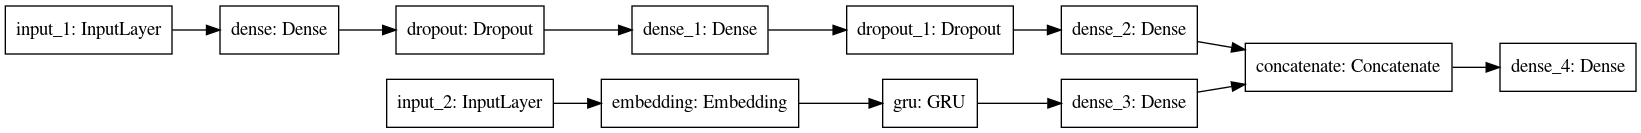

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(multi_input_model, rankdir='LR')

In [0]:
# Compilamos el modelo multi-input
multi_input_model.compile(loss='mse',
                          optimizer='adam',
                          metrics=[r2_score, 'mae'])

In [0]:
# Entrenamos el modelo multi-input
# Usamos una lista para las múltiples entradas de la red
multi_input_model.fit([input_train, train_sequences], y_train,
                      epochs=30, batch_size=32,
                      validation_split=0.1, callbacks=[es])

Train on 96842 samples, validate on 10761 samples
Epoch 1/30
96842/96842 [==============================] - 147s 2ms/sample - loss: 835.4099 - r2_score: 0.3413 - mae: 13.3930 - val_loss: 759.6141 - val_r2_score: 0.4080 - val_mae: 13.2416
Epoch 2/30
96842/96842 [==============================] - 152s 2ms/sample - loss: 679.7302 - r2_score: 0.4515 - mae: 11.9565 - val_loss: 686.5165 - val_r2_score: 0.4759 - val_mae: 11.9016
Epoch 3/30
96842/96842 [==============================] - 142s 1ms/sample - loss: 616.9909 - r2_score: 0.4849 - mae: 11.4217 - val_loss: 660.2146 - val_r2_score: 0.4312 - val_mae: 11.8033
Epoch 4/30
96842/96842 [==============================] - 134s 1ms/sample - loss: 563.2013 - r2_score: 0.5314 - mae: 10.9340 - val_loss: 622.3668 - val_r2_score: 0.5046 - val_mae: 11.3858
Epoch 5/30
96842/96842 [==============================] - 131s 1ms/sample - loss: 513.4572 - r2_score: 0.5586 - mae: 10.5764 - val_loss: 614.8463 - val_r2_score: 0.5218 - val_mae: 11.2478
Epoch 6/30

In [0]:
# Evaluamos el modelo en test
multi_input_model.evaluate([input_test, test_sequences], y_test)

11956/11956 [==============================] - 3s 267us/sample - loss: 844.7165 - r2_score: 0.5224 - mae: 10.7579


[844.7165446991345, 0.5223703, 10.757884]

¡Excelente! Gracias al aprendizaje conjunto de las ramas *fully-connected* y recurrente, esta red *multi-input* se desempeña mejor sobre el set de testeo que nuestro ensamble anterior.

In [0]:
# Predecimos
predictions = multi_input_model.predict([input_test, test_sequences])

In [0]:
# Comparamos predicciones con los valores reales y analizamos algunos casos puntuales
num_predictions = 20
idx = np.random.choice(range(len(X_test)), num_predictions)
diff = 0

for i in idx:
    y_pred = predictions[i][0]
    y_true = y_test.iloc[i]
    print('País:', X_test['country'].iloc[i], 'Provincia:', X_test['province'].iloc[i],
          'Variedad:', X_test['variety'].iloc[i], 'Puntos:', X_test['points'].iloc[i], '\n',
          X_test['description'].iloc[i])
    print('Precio predicho:', np.round(y_pred, 2), 'Precio real:', y_true,
          'Diferencia absoluta:', np.round(np.abs(y_pred - y_true), 2), '\n')
    diff += np.abs(y_pred - y_true)

País: US Provincia: California Variedad: Chardonnay Puntos: 92 
 Shows the weight, complexity and sheer deliciousness that this bottling almost always displays. Chardonnay fans will love the oaky, creamy flavors of pineapple tart, pear and lemon jam and buttered toast. The winemaker recommends pairing with black cod, and if you have a Chinese restaurant that makes a good version of this honey and soy inspired dish, it will be heaven.
Precio predicho: 26.48 Precio real: 26.0 Diferencia absoluta: 0.48 

País: France Provincia: Provence Variedad: Rosé Puntos: 90 
 A dusty-textured wine, its fruit like grains scattered over the surface of a fresh crisp structure. The freshness is palpable and so is the depth of flavor. A food-friendly wine.
Precio predicho: 34.27 Precio real: 37.0 Diferencia absoluta: 2.73 

País: France Provincia: Southwest France Variedad: Malbec Puntos: 93 
 The estate wine from this Cahors showpiece property, it shows the rich intensity that can be conjured from Malbec

## En resumen

- Tuvimos un primero contacto con la API funcional de Keras. Vimos cómo desarrollar las arquitecturas *fully-connected* y recurrentes con las que ya habíamos trabajado usando la clase `Sequential`, pero esta vez utilizando la clase `Model`.
- Construimos un modelo de ensamble a partir de estas dos redes distintas y predijimos el precio de los vinos a partir del promedio de la estimación de cada una de ellas.
- Hicimos *transfer learning* al incorporar los *word embeddings* de GloVe como representaciones densas de las palabras de los textos de las reseñas y los utilizamos para entrenar la red recurrente.
- Desarrollamos un modelo *multi-input* que se encarga de procesar los datos estructurados y no estructurados en una única arquitectura de red neuronal. Vimos que gracias al aprendizaje conjunto, este modelo *multi-input* logra superar la capacidad de generalización del ensamble anterior.